In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matplotlib.rcParams['savefig.dpi'] = 144
import seaborn

# Anomaly Dectection, Session 1

## Problem definition and data format

- Large amount of data; we aggregate to just look at trips per day

In [1]:
import pandas as pd
import zipfile
import glob

In [3]:
fns = glob.glob('tripdata/[0-9][0-9][0-9][0-9][0-9][0-9]-citibike-tripdata.zip')

def load_counts(fn):
    zf = zipfile.ZipFile(fn, 'r')
    df = pd.read_csv(zf.open(zf.namelist()[0]))
    counts = df['starttime'].str.split(' ', 1).apply(lambda x: x[0]).value_counts()
    if '-' in counts.index[0]:
        counts.index = pd.to_datetime(counts.index, format='%Y-%m-%d')
    else:
        counts.index = pd.to_datetime(counts.index, format='%m/%d/%Y')
    return counts.sort_index()

counts = pd.concat([load_counts(fn) for fn in sorted(fns)])

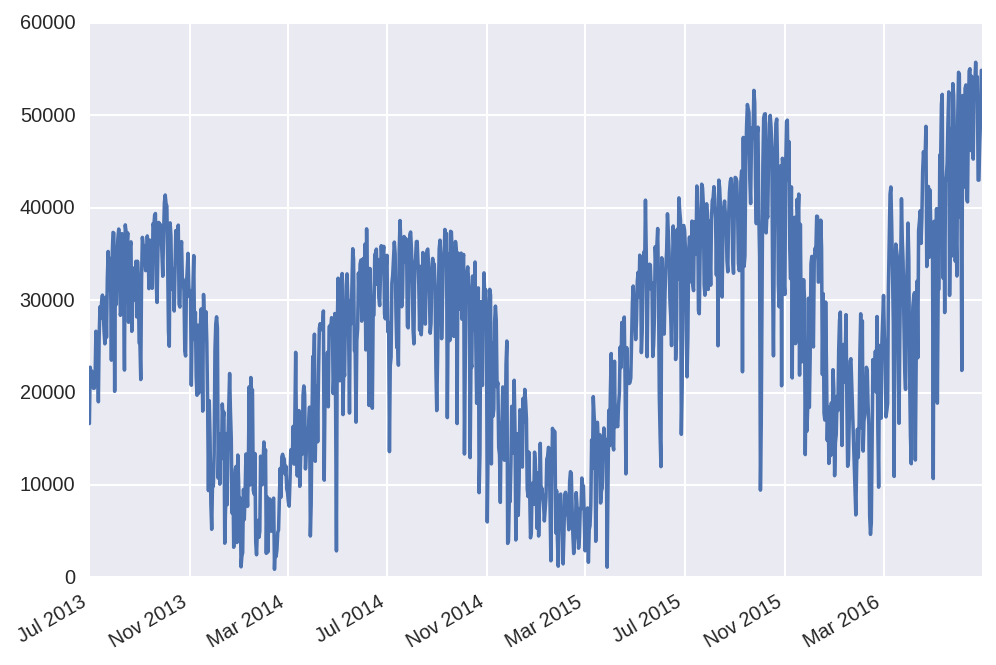

In [4]:
counts.plot()

## Detecting seasonality

- Autocorrelation
- FFT

In [8]:
import numpy as np

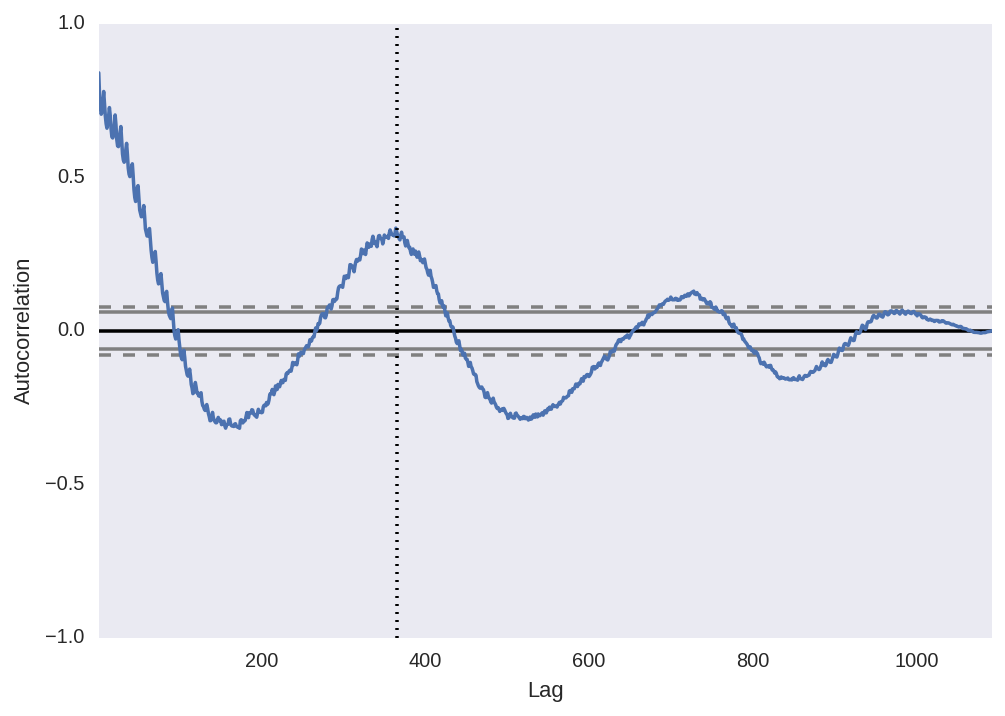

In [5]:
pd.tools.plotting.autocorrelation_plot(counts)
plt.axvline(365, color='k', ls=':')

(0, 60)

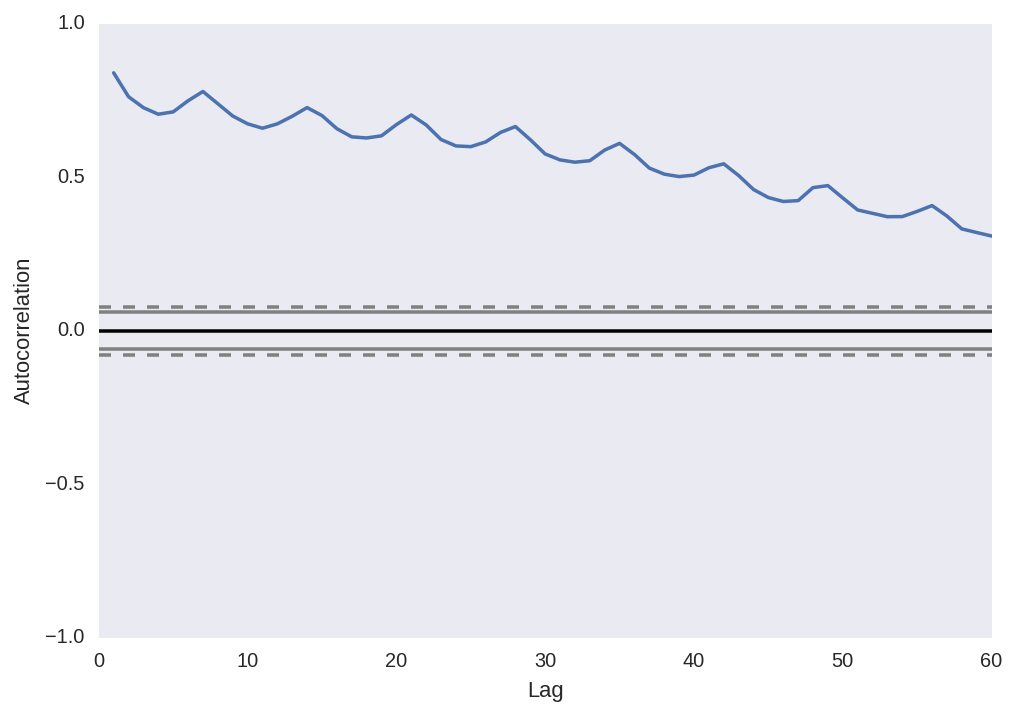

In [6]:
pd.tools.plotting.autocorrelation_plot(counts)
plt.xlim(0,60)

In [9]:
fft_counts = np.fft.fft(counts - counts.mean())

In [10]:
yrs = (counts.index[-1] - counts.index[0]).days / 365.

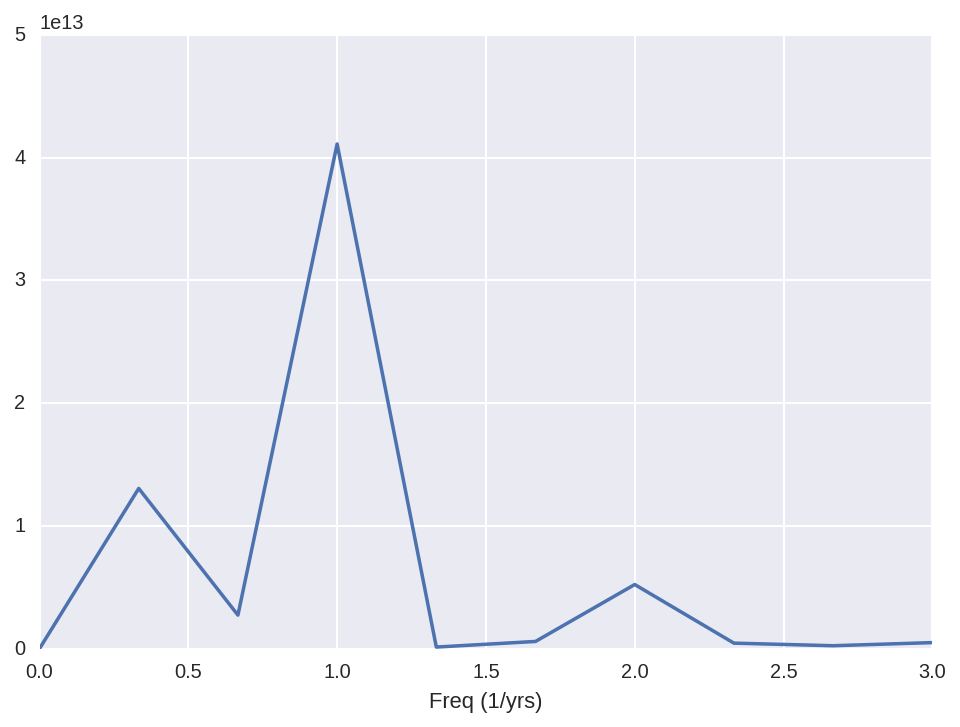

In [11]:
plt.plot(1.0*np.arange(len(fft_counts)) / yrs, np.abs(fft_counts)**2)
plt.axis([0,3, 0, 5e13])
plt.xlabel('Freq (1/yrs)')

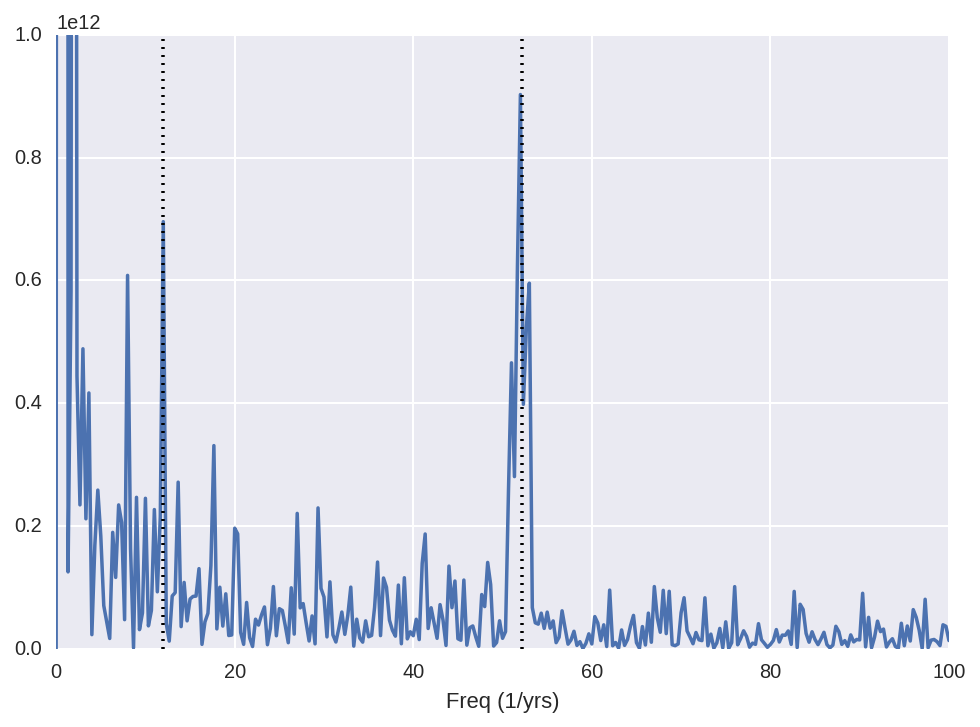

In [12]:
plt.plot(1.0*np.arange(len(fft_counts)) / yrs, np.abs(fft_counts)**2)
plt.axis([0,100, 0, 1e12])
plt.xlabel('Freq (1/yrs)')
plt.axvline(365/7., color='k', ls=':')
plt.axvline(12, color='k', ls=':')

## Detrending

- Remove yearly trend with FT
- Remove weekly trend with binning
- Leaves background trend -- remove with quadratic fit

In [14]:
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [15]:
class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, period):
        self.period = period
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]

In [16]:
class DaysSinceQuad(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        days = (X - self.X0).days
        return np.c_[days, days**2]

In [17]:
union = FeatureUnion([('date', DaysSinceQuad()),
                      ('fourier', FourierComponents(365))])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

In [18]:
pipe.fit(counts.index, counts.values)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('date', DaysSinceQuad()), ('fourier', FourierComponents(period=365))],
       transformer_weights=None)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

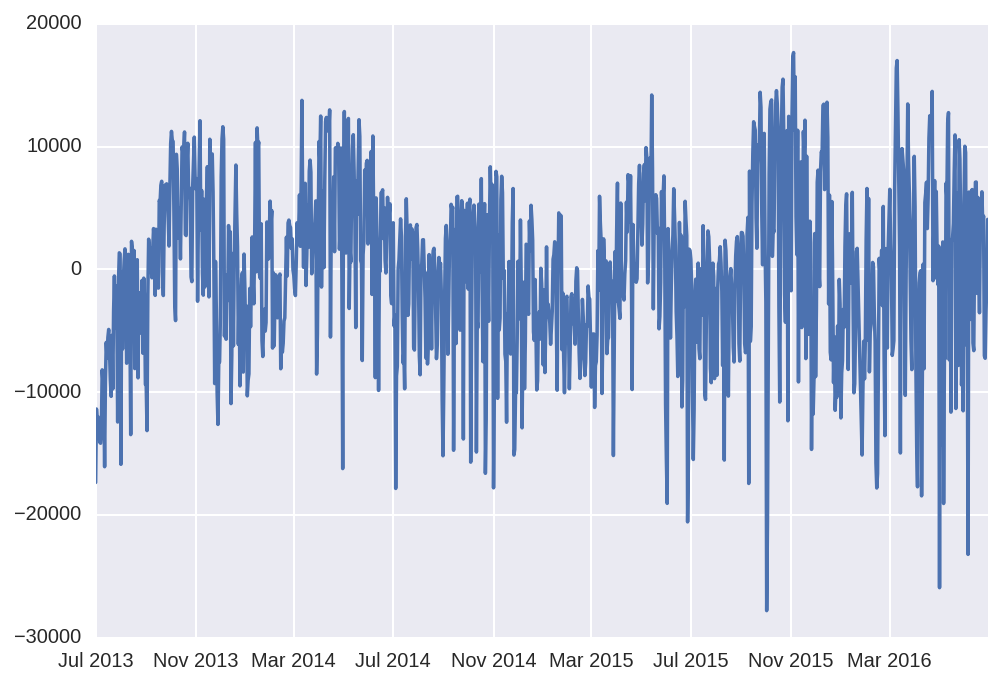

In [19]:
plt.plot(counts - pipe.predict(counts.index))

In [20]:
np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index)))

6993.1120344856336

In [21]:
class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def day_vector(self, day):
        v = np.zeros(7)
        v[day] = 1
        return v
    
    def transform(self, X):
        return np.stack(self.day_vector(d) for d in X.dayofweek)

In [22]:
union = FeatureUnion([('date', DaysSinceQuad()),
                      ('fourier', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

In [23]:
pipe.fit(counts.index, counts.values)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('date', DaysSinceQuad()), ('fourier', FourierComponents(period=365)), ('dayofweek', DayofWeek())],
       transformer_weights=None)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

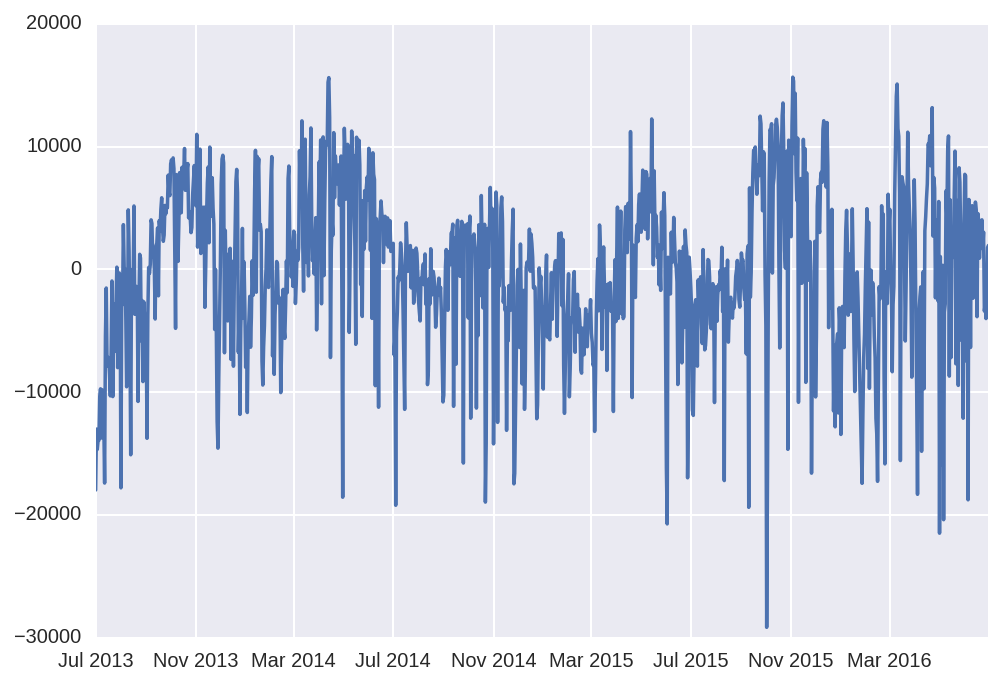

In [25]:
plt.plot(counts - pipe.predict(counts.index))

In [26]:
np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index)))

6502.0455715592234

## Simple detection algorithms

- Once detrended, just look for things far from the mean
- z-score measures value relative expected variation
- Here, positive and negative variation seem different, so check separately

In [27]:
residual = counts - pipe.predict(counts.index)

In [28]:
(abs(residual) > 2.5 *residual.std()).sum()

21

In [29]:
residual[residual > 2 *residual.std()]

2014-04-12    15238.027063
2014-04-13    15614.251789
2015-10-22    13548.893622
2015-11-03    15654.449711
2015-11-04    15332.485825
2015-11-06    14333.432109
2016-03-09    14097.256463
2016-03-10    15091.275706
2016-04-22    13170.326214
Name: starttime, dtype: float64

March 9, 10 2016 -- good weather (79 vs. 48 usually on the 10th)

In [30]:
residual[residual < -3 *residual.std()]

2015-06-02   -20739.032294
2015-10-02   -29163.301650
2016-05-01   -21494.735903
2016-05-06   -20396.539937
Name: starttime, dtype: float64

May 1, 6 a bit cooler than normal; October 2: nor'easter

## Exercises

1. Account for monthly seasonality.  What does it look like?  How to model?

2. Correlate with temperature data.  (Find a source.)